In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

#from warnings import filterwarnings
#filterwarnings('ignore')

data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
loans = pd.read_csv('kiva_loans.csv')

loans.head(1)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.000,300.000,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.000,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.000,12,NaN,female,irregular,2014-01-01


In [3]:
region = pd.read_csv('kiva_mpi_region_locations.csv')

print(region.shape)

region.head(1)

(2772, 9)


,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.735,70.812


In [4]:
loan_theme_ids = pd.read_csv('loan_theme_ids.csv')

print(loan_theme_ids.shape)

loan_theme_ids.head(1)

(779092, 4)


,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.000


In [5]:
loan_themes_byregion = pd.read_csv('loan_themes_by_region.csv')

print(loan_themes_byregion.shape)

loan_themes_byregion['region'].value_counts()

(15736, 21)


Chouf                                                 25
Tripoli                                               23
Nabatieh                                              23
Nablus                                                22
La UniÍ_n                                             21
San Vicente                                           21
UsulutÍn                                             20
Nairobi                                               20
Aley                                                  20
Saida                                                 19
Beirut                                                18
Spitamen                                              17
Qana                                                  17
Istaravshan                                           17
Gaza City- Gaza Strip                                 16
Kampala                                               16
Dier Al-Balah, Gaza Strip                             16
San Miguel                     

In [6]:
data = pd.merge(loans, loan_theme_ids, on='id')
data = pd.merge(data, loan_themes_byregion, on='region')

In [7]:
countries = loans['country'].value_counts().head(50)
trace = go.Bar(
    y=countries.index[::-1],
    x=countries.values[::-1],
    orientation = 'h',
    marker=dict(
        color=countries.values[::-1],
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Country wise distribution of loans',
    width=700,
    height=1000,
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CountryLoan")

In [8]:
con_df = pd.DataFrame(loans['country'].value_counts()).reset_index()
con_df.columns = ['country', 'num_loans']
con_df = con_df.reset_index().drop('index', axis=1)

#Find out more at https://plot.ly/python/choropleth-maps/
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_loans'],
        text = con_df['country'],
        #colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(56, 142, 60)']],
        #colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(220, 83, 67)']],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.85,"rgb(40, 60, 190)"],[0.9,"rgb(70, 100, 245)"],\
            [0.94,"rgb(90, 120, 245)"],[0.97,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of Loans'),
      ) ]

layout = dict(
    title = 'Number of loans by Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='loans-world-map')

In [9]:
sectors = loans['sector'].value_counts().head(25)
trace = go.Bar(
    y=sectors.index[::-1],
    x=sectors.values[::-1],
    orientation = 'h',
    marker=dict(
        color=sectors.values[::-1],
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = dict(
    title='Sector wise distribution of loans',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="SectorLoan")

In [10]:
activities = loans['activity'].value_counts().head(25)
trace = go.Bar(
    y=activities.index[::-1],
    x=activities.values[::-1],
    orientation = 'h',
    marker=dict(
        color=activities.values[::-1],
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = dict(
    title='Activity wise distribution of loans',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivityLoan")

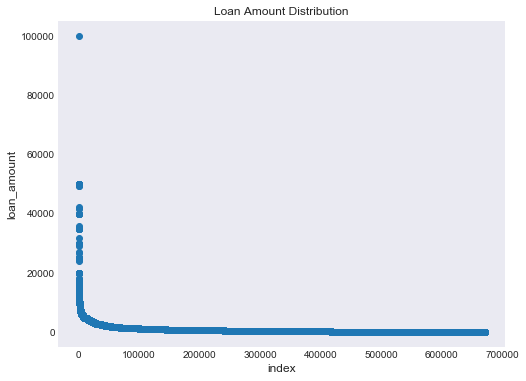

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(range(loans.shape[0]), [i for i in reversed(np.sort(loans.loan_amount.values))])
plt.xlabel('index', fontsize=12)
plt.ylabel('loan_amount', fontsize=12)
plt.title("Loan Amount Distribution")
plt.show()

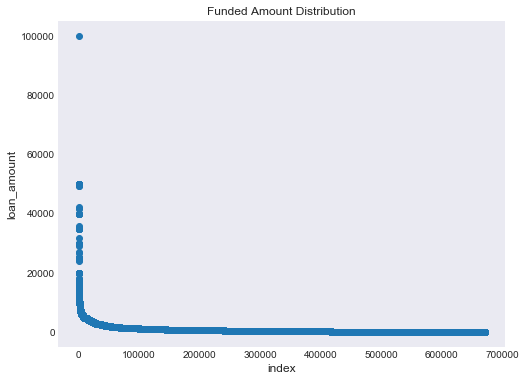

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(range(loans.shape[0]), [i for i in reversed(np.sort(loans.loan_amount.values))])
plt.xlabel('index', fontsize=12)
plt.ylabel('loan_amount', fontsize=12)
plt.title("Funded Amount Distribution")
plt.show()

C:\Users\Vince\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



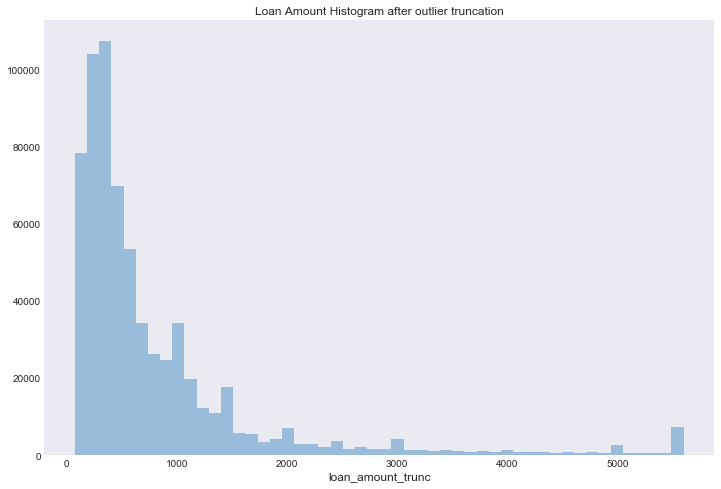

In [13]:
ulimit = np.percentile(loans.loan_amount.values, 99)
llimit = np.percentile(loans.loan_amount.values, 1)
loans['loan_amount_trunc'] = loans['loan_amount'].copy()
loans['loan_amount_trunc'].loc[loans['loan_amount'] > ulimit] = ulimit
loans['loan_amount_trunc'].loc[loans['loan_amount'] < llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(loans.loan_amount_trunc.values, bins=50, kde=False)
plt.xlabel('loan_amount_trunc', fontsize=12)
plt.title("Loan Amount Histogram after outlier truncation")
plt.show()

In [14]:
terms = loans.term_in_months.value_counts().head(40)

trace = go.Bar(
    x=terms.index,
    y=terms.values,
    marker=dict(
        color=terms.values,
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Repayment Term in Months'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="RepaymentIntervals")

# Machine Learning

In [15]:
loans['y'] = (loans['loan_amount'] != loans['funded_amount']).astype(int)

loans.sample(20)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,loan_amount_trunc,y
60177,712439,825.000,825.000,General Store,Retail,to purchase a meat grinder,PH,Philippines,"Ozamiz - Lapasan, Clarin",PHP,...,2014-05-16 07:00:00+00:00,2014-05-24 20:03:13+00:00,8.000,12,NaN,female,irregular,2014-05-20,825.000,0
329280,976200,425.000,425.000,Pigs,Agriculture,to buy feed and vitamins for her pigs,PH,Philippines,"Maasin City, Leyte",PHP,...,2015-10-29 07:00:00+00:00,2015-11-23 13:04:12+00:00,8.000,16,"#Animals, #Parent, #Repeat Borrower, #Woman Ow...",female,irregular,2015-11-10,425.000,0
334619,981425,125.000,125.000,Consumer Goods,Personal Use,"to buy food and clothing, eliminating pressure...",NG,Nigeria,Kaduna,NGN,...,2015-12-07 08:00:00+00:00,2015-11-24 03:18:30+00:00,14.000,3,NaN,male,bullet,2015-11-19,125.000,0
290934,937794,500.000,500.000,Livestock,Agriculture,"to buy a heifer, a cow and three pigs.",SV,El Salvador,NaN,USD,...,2015-08-24 07:00:00+00:00,2015-09-14 00:20:32+00:00,13.000,15,"#Animals, #Parent, #Woman Owned Biz, user_favo...",female,bullet,2015-08-24,500.000,0
4644,657625,3275.000,3275.000,Sewing,Services,to purchase fabric and thread.,PY,Paraguay,Santaní,PYG,...,2013-12-16 08:00:00+00:00,2014-02-07 04:41:21+00:00,9.000,52,"#Fabrics, #Woman Owned Biz, #Supporting Family","female, female, female, female, female, female...",irregular,2014-01-15,3275.000,0
456816,1116785,1350.000,1350.000,Clothing Sales,Clothing,to buy more maize and clothes,MW,Malawi,Chikwawa,MWK,...,2016-06-17 07:00:00+00:00,2016-07-24 19:45:16+00:00,8.000,29,"#Elderly, user_favorite, user_favorite","female, female, female, female",monthly,2016-07-15,1350.000,0
521819,1182360,200.000,200.000,Crafts,Arts,"to buy beads, different kinds of stones and ot...",TR,Turkey,NaN,TRY,...,2016-10-10 07:00:00+00:00,2016-11-17 13:26:08+00:00,7.000,8,"#Woman Owned Biz, #Repeat Borrower, #Parent",female,irregular,2016-11-09,200.000,0
410490,1057199,900.000,900.000,Agriculture,Agriculture,to purchase mineral fertilizers.,TJ,Tajikistan,Jilikul,TJS,...,2016-04-07 07:00:00+00:00,2016-05-25 18:18:15+00:00,14.000,34,"#Parent, #Vegan",male,monthly,2016-04-20,900.000,0
317514,964334,350.000,350.000,General Store,Retail,"to purchase an assortment in bulk (pastries, c...",CO,Colombia,Bello,COP,...,2015-09-22 07:00:00+00:00,2015-10-31 13:23:20+00:00,14.000,14,"user_favorite, #Parent, #Woman Owned Biz",female,bullet,2015-10-16,350.000,0
426350,1072895,125.000,125.000,Butcher Shop,Food,to bolster her stock of meat to sell.,HT,Haiti,Hinche,HTG,...,2016-04-26 07:00:00+00:00,2016-05-27 14:31:08+00:00,8.000,4,NaN,female,monthly,2016-05-21,125.000,0


In [16]:
del loans['disbursed_time']
del loans['funded_time']
del loans['funded_amount']
del loans['id']
del loans['country']
del loans['posted_time']
del loans['lender_count']
del loans['date']
del loans['loan_amount_trunc']

In [17]:
loans['num_borrowers'] = loans.borrower_genders.str.count(',')

In [18]:
x = loans.drop(['tags', 'use', 'partner_id', 'borrower_genders', 'y'], axis=1)
y = loans['y']

In [19]:
x = pd.get_dummies(x)

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(x)
x = pca.transform(x)

MemoryError: 

In [20]:
x = x.select_dtypes('number')

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=.2)

MemoryError: 

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier()
params = {'max_depth': list(np.arange(2,5)),
         'reg_lambda': np.arange(1, 1.5, .1),
         'n_estimators': [100, 200, 300]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

In [ ]:
# Deep Learning

In [ ]:
#HANDLE MISSING VALUES
def handle_missing(dataset, cols):
    for col in cols:
        dataset[col].fillna(value="_LEFTBLANK_", inplace=True)
    return dataset

loans = handle_missing(loans, ['use', 'tags', 'activity', 'sector', 'country_code', 'currency'])

In [21]:
from sklearn.preprocessing import LabelEncoder

#PROCESS CATEGORICAL DATA
for i in 'activity sector country_code currency'.split():
    labeler = LabelEncoder()
    
    labeler.fit(loans[i])

    loans[i] = labeler.transform(loans[i])

TypeError: unorderable types: float() < str()

In [ ]:
repay = pd.get_dummies(loans['repayment_interval'])

loans = pd.concat([loans, repay], axis=1)
del loans['repayment_interval']

In [ ]:
loans['female_borrower'] = np.where(loans['borrower_genders'].str.contains('fe'), 1, 0)

In [ ]:
#PROCESS RAW TEXT
# 1. Gather raw text
# 2. Fit tokenizer to it
# 3. Convert item names and descriptions to token sequences

from keras.preprocessing.text import Tokenizer

print("Fitting tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(loans['use'].str.lower())

print("Transforming text to seq...")
loans["loan_description"] = tokenizer.texts_to_sequences(loans['use'].str.lower())

In [ ]:
#PROCESS RAW TEXT
# 1. Gather raw text
# 2. Fit tokenizer to it
# 3. Convert item names and descriptions to token sequences

from keras.preprocessing.text import Tokenizer

print("Fitting tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(loans['tags'].str.lower())

print("Transforming text to seq...")
loans["tag_seq"] = tokenizer.texts_to_sequences(loans['tags'].str.lower())

In [ ]:
#SEQUENCES VARIABLES ANALYSIS
loan_desc_len = loans["loan_description"].apply(len)
print("max desc seq:", loan_desc_len.max())

loan_tag_len = loans["tag_seq"].apply(len)
print("max tag seq:", loan_tag_len.max())

In [ ]:
# CREATE VALIDATION DATA
# y = loans.pop('y')
xtrain, xtest, ytrain, ytest = train_test_split(loans, y, test_size=.2)

print(xtrain.shape)
print(xtest.shape)

In [ ]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths

MAX_DESC_SEQ = 60
MAX_TAG_SEQ = 30

tokenizer.fit_on_texts(loans['use'].str.lower())
MAX_TOKEN = len(tokenizer.word_index) + 1
# 26207

MAX_ACTIVITY = np.max(loans.activity) + 1
MAX_SECTOR = np.max(loans.sector) + 1
MAX_COUNTRY = np.max(loans.country_code) + 1
MAX_CURRENCY = np.max(loans.currency) + 1

In [ ]:
# KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'loan_desc': pad_sequences(dataset.loan_description, maxlen=MAX_DESC_SEQ),
        'tag_desc': pad_sequences(dataset.tag_seq, maxlen=MAX_TAG_SEQ),
        'loans_activity': np.array(dataset.activity),
        'loans_sector': np.array(dataset.sector),
        'loans_country_code': np.array(dataset.country_code),
        'loans_currency': np.array(dataset.currency),
    }
    return X

# X
X_train = get_keras_data(xtrain)
X_val = get_keras_data(xtest)

# X_test = get_keras_data(test)

# Y
y_train = ytrain
y_val = ytest